# Generate circlized plot for schizophrenia analysis DEG results

In [1]:
library(biomaRt)
library(circlize)
library(tidyverse)
library(ComplexHeatmap)

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks biomaRt::select()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https:

## Prepare data

### Get gene annotation

In [2]:
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
biomart = getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 
                             'start_position', 'end_position'), mart=ensembl)
biomart %>% head(2)

,ensembl_gene_id,chromosome_name,start_position,end_position
,<chr>,<chr>,<int>,<int>
1,ENSG00000210049,MT,577,647
2,ENSG00000211459,MT,648,1601


### Get logFC for differential expression analysis

In [3]:
deg = data.table::fread("../../_m/genes/diffExpr_szVctl_full.txt") %>%
    select(gencodeID, ensemblID, Symbol, logFC, "adj.P.Val")
deg %>% head(2)

gencodeID,ensemblID,Symbol,logFC,adj.P.Val
<chr>,<chr>,<chr>,<dbl>,<dbl>
ENSG00000248587.7,ENSG00000248587,GDNF-AS1,0.8015019,1.387742e-26
ENSG00000138944.7,ENSG00000138944,KIAA1644,0.5637328,1.707516e-24


### Merge data and select regions

In [4]:
bed = deg %>% 
    inner_join(biomart, by=c("ensemblID"="ensembl_gene_id")) %>%
    select(chromosome_name, start_position, end_position, logFC, "adj.P.Val") %>%
    mutate(chromosome_name=paste0('chr', chromosome_name))

bed_sz = bed %>% filter(logFC > 0, adj.P.Val < 0.05)
bed_ctl = bed %>% filter(logFC < 0, adj.P.Val < 0.05)
bed_nonsig = bed %>% filter(adj.P.Val > 0.05)

## Circos Plot

In [5]:
plot_circos <- function(bed_list, colors, tissue_name){
    lgd_points = Legend(at=c("Upregulated in SZ", "Downregulated in SZ"), 
                        type="points", legend_gp=gpar(col = c("red", "blue")), 
                        title_position="topleft", title="DE Analysis", 
                        background="#FFFFFF")
    circos.clear() # clear plot if there is any
    circos.par("start.degree" = 0) # rotate 90 degrees
    # initialize with ideogram
    # use hg38, default is hg19
    circos.initializeWithIdeogram(species="hg38") 
    # add logFC as a genomic track
    circos.genomicTrack(bed_list, track.height=inches_h(1),
                        text(0, 0, tissue_name, cex = 1.5),
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = colors[i], ...)
    })
    draw(lgd_points, x=unit(5, "mm"), y=unit(5, "mm"), just=c("left", "bottom"))
}

In [6]:
tissue = 'Caudate Nucleus'
tissue_name = gsub(" ", "_", tissue)

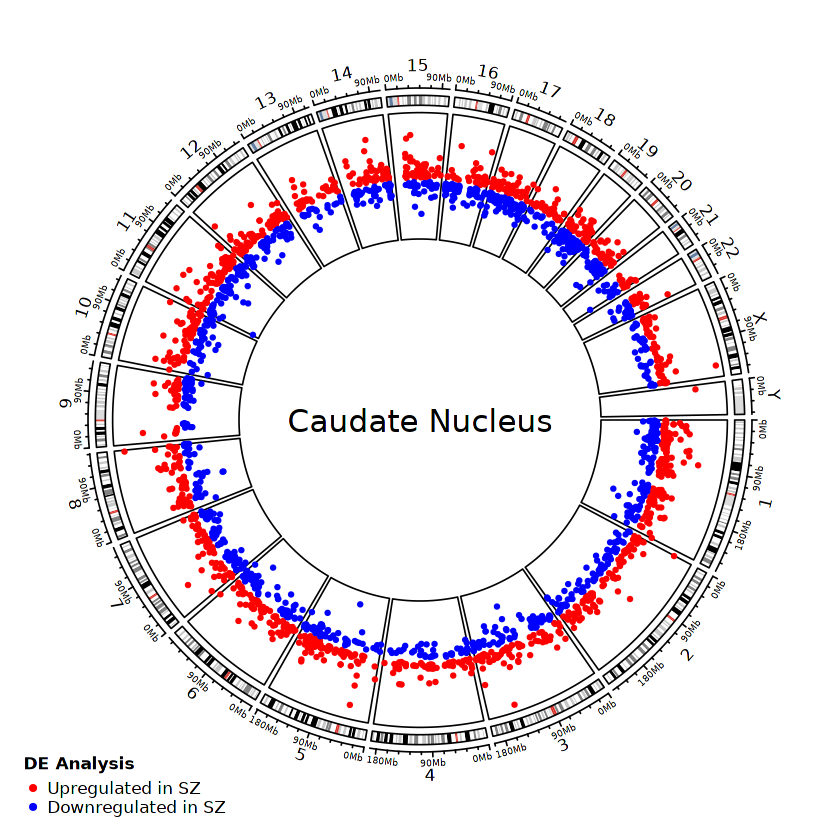

In [7]:
plot_circos(list(bed_sz, bed_ctl), c("red", "blue"), tissue)

In [8]:
png(filename = paste0("significant_circos_plot_", tissue_name, ".png"))
plot_circos(list(bed_sz, bed_ctl), c("red", "blue"), tissue)
dev.off()

pdf(file = paste0("significant_circos_plot_", tissue_name, ".pdf"))
plot_circos(list(bed_sz, bed_ctl), c("red", "blue"), tissue)
dev.off()

svg(filename = paste0("significant_circos_plot_", tissue_name, ".svg"))
plot_circos(list(bed_sz, bed_ctl), c("red", "blue"), tissue)
dev.off()

png 
  2

png 
  2

png 
  2

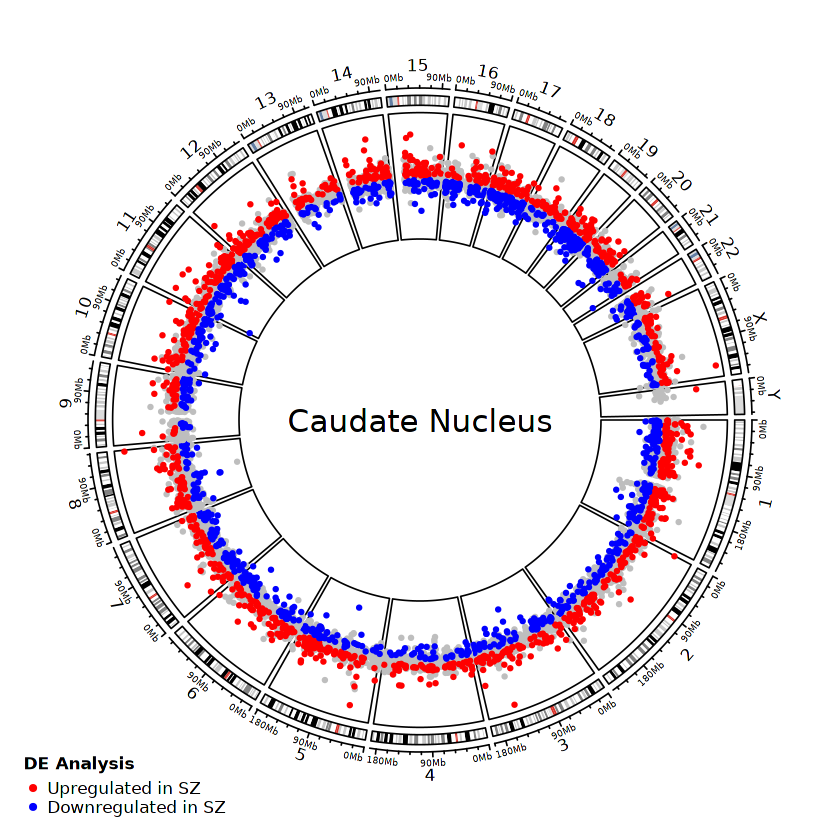

In [9]:
plot_circos(list(bed_nonsig, bed_sz, bed_ctl), 
            c("gray", "red", "blue"), tissue)

In [10]:
png(filename = paste0("allGenes_circos_plot_", tissue_name, ".png"))
plot_circos(list(bed_nonsig, bed_sz, bed_ctl), 
            c('gray', 'red', 'blue'), tissue)
dev.off()

pdf(file = paste0("allGenes_circos_plot_", tissue_name, ".pdf"))
plot_circos(list(bed_nonsig, bed_sz, bed_ctl), 
            c('gray', 'red', 'blue'), tissue)
dev.off()

svg(filename = paste0("allGenes_circos_plot_", tissue_name, ".svg"))
plot_circos(list(bed_nonsig, bed_sz, bed_ctl), 
            c('gray', 'red', 'blue'), tissue)
dev.off()

png 
  2

png 
  2

png 
  2

## Repreducibility Information

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-09-06 08:41:54 EDT"

   user  system elapsed 
 51.516   0.743  59.749 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-09-06                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package        * version  date       lib source        
 AnnotationDbi    1.52.0   2020-10-27 [1] Bioconductor  
 askpass          1.1      2019-01-13 [1] CRAN (R 4.0.2)
 assertthat       0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports        1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc        0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 Biobase          2.50.0   20